In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn import metrics
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.metrics import adjusted_rand_score
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier as MLP
from tabulate import tabulate
from itertools import product
from sklearn.metrics import recall_score, accuracy_score, confusion_matrix
from tabulate import tabulate

In [ ]:
# Code to read csv file into Colaboratory:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

link = 'https://drive.google.com/file/d/12M6NYn2Ci-TxdDJVJs7aodzW8mJKlp9E/view?usp=drive_link' # The shareable link

id = link.split("/")[-2]

downloaded = drive.CreateFile({'id':id})
downloaded.GetContentFile('falldetection_dataset.csv')

df = pd.read_csv('falldetection_dataset.csv', header=None)
features = df.iloc[:, 2:].values
labels = df.iloc[:, 1].values

Cumulative explained variance ratio:
PC 1: 75.31%
PC 2: 83.82%
F
NF


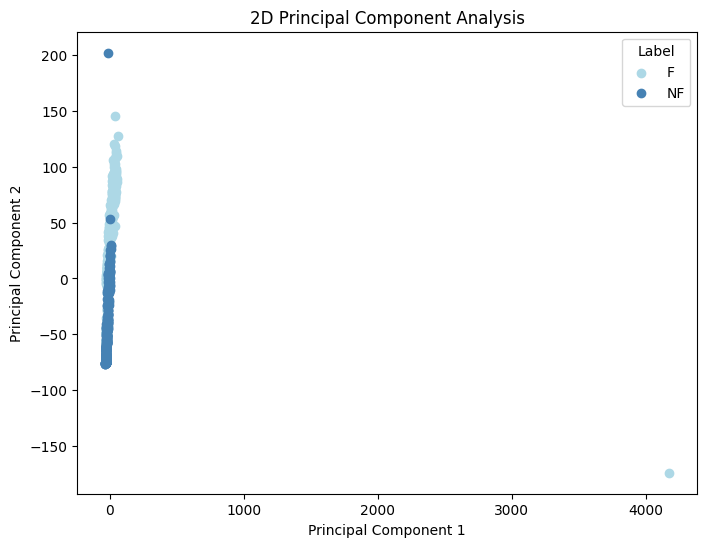

In [ ]:
pca = PCA(n_components=2)
principal_components = pca.fit_transform(features)

explained_variance_ratio = pca.explained_variance_ratio_
eig_vals = pca.explained_variance_
sorted_eigenvalues = sorted(eig_vals, reverse=True)
cumulative_var_ratio = np.cumsum(explained_variance_ratio)*100

print("Cumulative explained variance ratio:")
for i, var_ratio in enumerate(cumulative_var_ratio, 1):
    print(f"PC {i}: {var_ratio:.2f}%")

plt.figure(figsize=(8, 6))
for label_val in np.unique(labels):
    print (label_val)
    if label_val == "F":
        color = 'lightblue'
    else:
        color = 'steelblue'
    plt.scatter(
        principal_components[labels == label_val, 0],
        principal_components[labels == label_val, 1],
        label=label_val,
        color=color
    )
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('2D Principal Component Analysis')
plt.legend(title='Label', loc='upper right')
plt.show()

In [ ]:
outlier1_idx = np.argmax(principal_components[:, 0])
outlier2_idx = np.argmax(principal_components[:, 1])

features_no_outlier = np.delete(features, [outlier1_idx, outlier2_idx], axis=0)
labels_no_outlier = np.delete(labels, [outlier1_idx, outlier2_idx], axis=0)

Cumulative explained variance ratio:
PC 1: 26.65%
PC 2: 48.71%


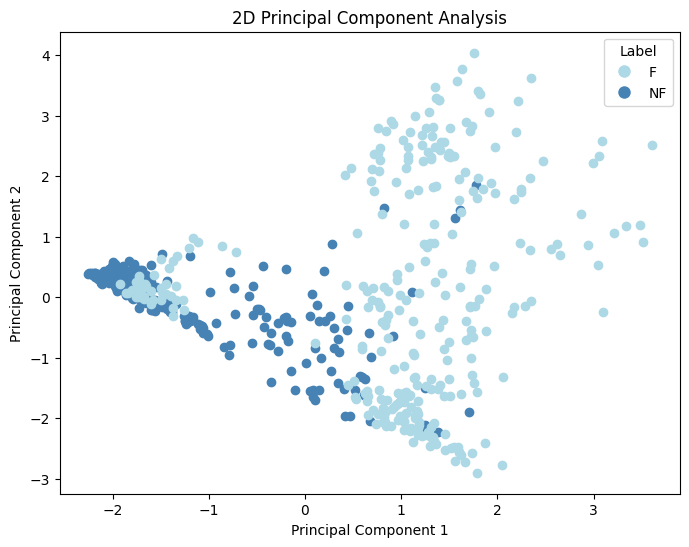

In [ ]:
scaler = MinMaxScaler()

features_scaled = scaler.fit_transform(features_no_outlier)

labels_mapped = np.where(labels_no_outlier == 'F', 1, 0)

pca2 = PCA(n_components=2)
transformed_data = pca2.fit_transform(features_scaled)

explained_variance_ratio = pca2.explained_variance_ratio_
eig_vals = pca2.explained_variance_
sorted_eigenvalues = sorted(eig_vals, reverse=True)
cumulative_var_ratio = np.cumsum(explained_variance_ratio) * 100

print("Cumulative explained variance ratio:")
for i, var_ratio in enumerate(cumulative_var_ratio, 1):
    print(f"PC {i}: {var_ratio:.2f}%")


plt.figure(figsize=(8, 6))
for label_val in np.unique(labels_mapped):
    if label_val == 1:
        color = 'lightblue'
        label_text = 'F'
    else:
        color = 'steelblue'
        label_text = 'NF'
    plt.scatter(
        transformed_data[labels_mapped == label_val, 0],
        transformed_data[labels_mapped == label_val, 1],
        label=label_text,
        color=color
    )
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('2D Principal Component Analysis')
plt.legend(title='Label', handles=[
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='lightblue', markersize=10, label='F'),
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='steelblue', markersize=10, label='NF')
], loc='upper right')
plt.show()

In [ ]:
def cluster_prediction_mapping(labels, predictions, cluster_num):
    mapped_predictions = predictions.copy()
    for i in range(cluster_num):
        indexes = np.where(predictions == i)[0]
        F_count = np.count_nonzero(labels[indexes] == 1)
        NF_count = np.count_nonzero(labels[indexes] == 0)
        mapped_predictions[indexes] = 1 if F_count > NF_count else 0
    return mapped_predictions

def cluster_accuracy(labels, predictions, cluster_num):
    mapped_predictions = cluster_prediction_mapping(labels, predictions, cluster_num)
    return metrics.accuracy_score(labels, mapped_predictions)

def plot_clusters(X, labels, cluster_mapping_score):
    unique_labels = np.unique(labels)
    cmap = plt.get_cmap('tab20')
    for i, label in enumerate(unique_labels):
        cluster_points = X[labels == label]
        plt.scatter(cluster_points[:, 0], cluster_points[:, 1], label=f'Cluster {label}', color=cmap(i))
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.title(f'K-Means with {i + 1} Clusters \nCluster Mapping Accuracy: {cluster_mapping_score:.4f}')
    plt.legend(title='Cluster', loc='upper left')
    plt.show()

K-Means Clustering

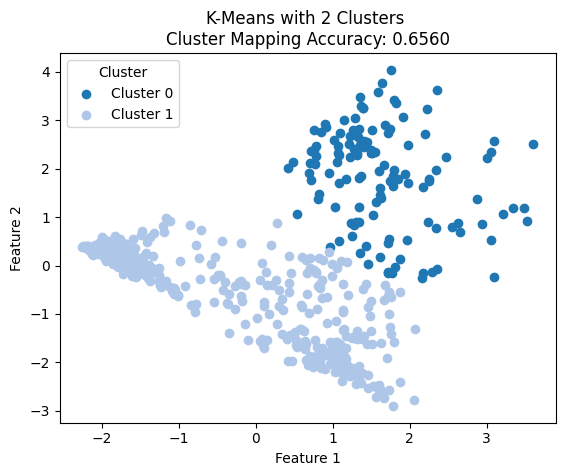

Cluster 0: Falls - 122, Non-Falls - 4
Cluster 1: Falls - 190, Non-Falls - 248


In [ ]:
cluster_num = 2
kmeans = KMeans(n_clusters=cluster_num, random_state=42, n_init='auto')
cluster_predictions = kmeans.fit_predict(transformed_data)
cluster_mapping_score = cluster_accuracy(labels_mapped, cluster_predictions, cluster_num=cluster_num)
plot_clusters(transformed_data, cluster_predictions, cluster_mapping_score)

unique_clusters, cluster_counts = np.unique(cluster_predictions, return_counts=True)
for cluster_id, count in zip(unique_clusters, cluster_counts):
    fall_count = sum(labels_mapped[cluster_predictions == cluster_id] == 1)
    non_fall_count = sum(labels_mapped[cluster_predictions == cluster_id] == 0)
    print(f"Cluster {cluster_id}: Falls - {fall_count}, Non-Falls - {non_fall_count}")

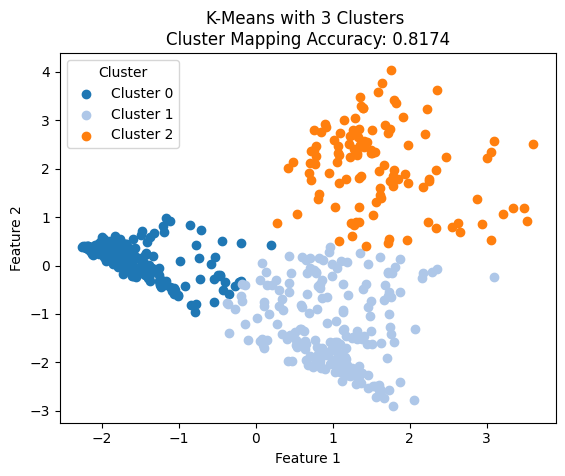

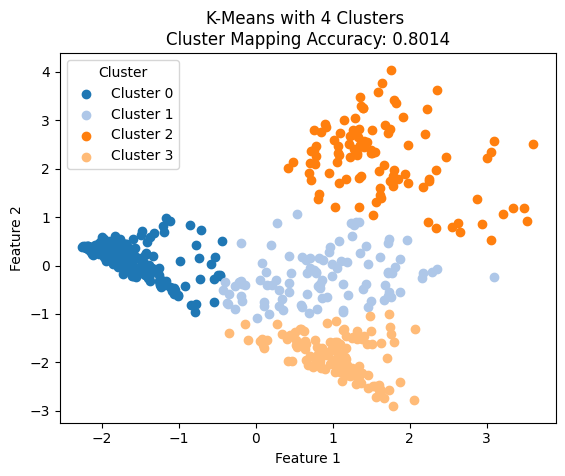

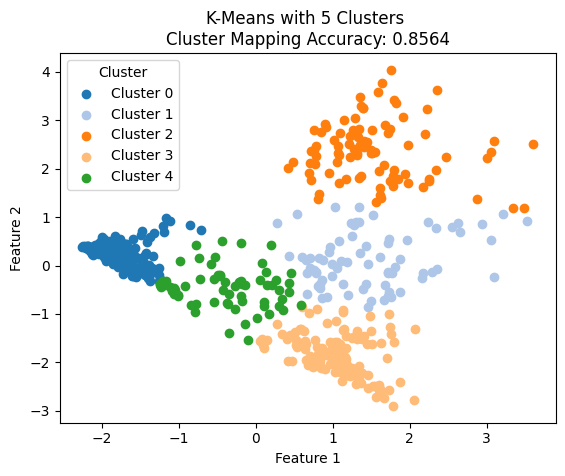

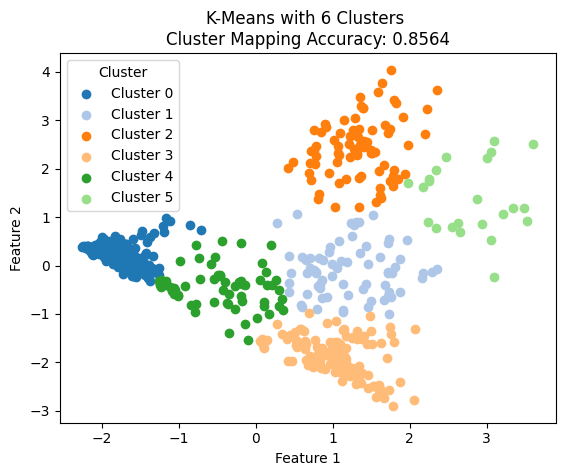

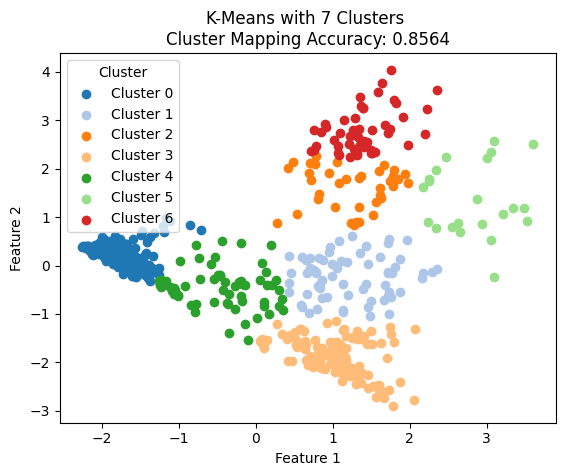

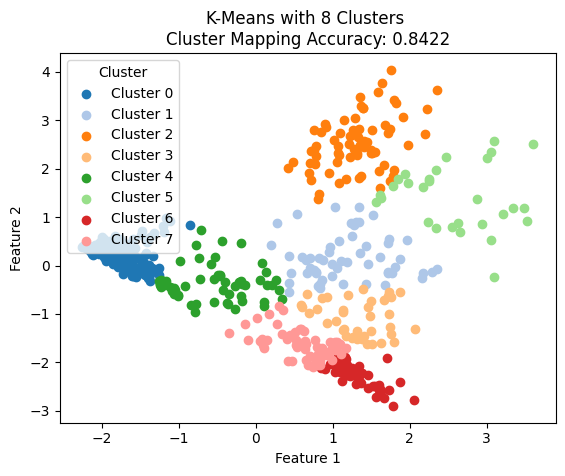

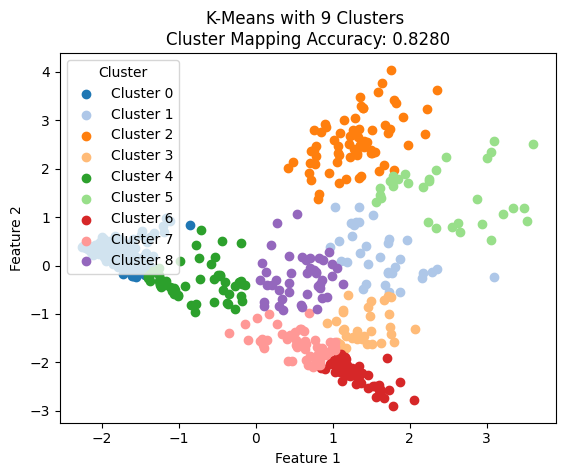

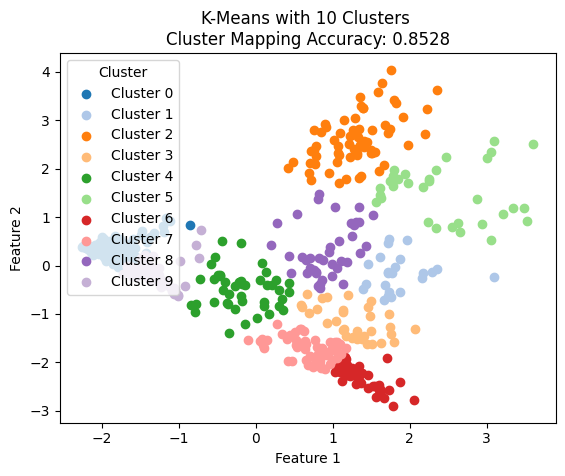

In [ ]:
for i in range(2,10):
    cluster_num = i + 1
    kmeans = KMeans(n_clusters=cluster_num, random_state=22, n_init='auto')
    cluster_predictions = kmeans.fit_predict(transformed_data)
    cluster_mapping_score = cluster_accuracy(labels_mapped, cluster_predictions, cluster_num=cluster_num)
    plot_clusters(transformed_data, cluster_predictions, cluster_mapping_score)

Part B

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(transformed_data, labels_mapped, test_size=0.30, random_state=42)
x_val, x_test, y_val, y_test = train_test_split(x_test, y_test, test_size=0.50, random_state=42)

In [ ]:
c_values = [0.001, 0.01, 0.1, 1.0, 10.0]
kernel_types = ["rbf", "linear", "sigmoid", "poly"]
gamma_values = ["scale", "auto"]
degrees = [0, 1, 2, 3, 4, 5]

svm_hyperparams = list(product(c_values, kernel_types, gamma_values, degrees))

all_results_svm = []
for c, kernel_type, gamma, degree in svm_hyperparams:
    model_params = {'C': c, 'kernel': kernel_type, 'gamma': gamma,
                    'max_iter': 100000, 'random_state': 42}
    if kernel_type == 'poly':
        model_params['degree'] = degree

    model = SVC(**model_params)
    model.fit(x_train, y_train)
    predictions = model.predict(x_val)

    val_recall = recall_score(y_val, predictions, pos_label=1) * 100
    val_accuracy = accuracy_score(y_val, predictions) * 100

    all_results_svm.append((c, kernel_type, gamma, degree, val_recall, val_accuracy))

all_results_svm.sort(key=lambda item: (item[5], item[4]), reverse=True)

best_result = all_results_svm[0]
svm_best_c, svm_best_kernel, svm_best_gamma, svm_best_degree, svm_best_val_recall, svm_best_val_accuracy = best_result

print(f'The settings of the best SVM model: c={svm_best_c}, kernel_type={svm_best_kernel}, gamma={svm_best_gamma}, degree={svm_best_degree}')
print(f'The best validation recall: {svm_best_val_recall:.2f}%')
print(f'The best validation accuracy: {svm_best_val_accuracy:.2f}%')

headers = ["C", "Kernel Type", "Gamma", "Validation Recall (%)", "Validation Accuracy (%)"]


unique_rows = set()
table_data = []
for c, kernel_type, gamma, degree, val_recall, val_accuracy in all_results_svm:
    if kernel_type == 'poly':
        kernel_type_display = f'{kernel_type}(degree={degree})'
    else:
        kernel_type_display = kernel_type
    row = [c, kernel_type_display, gamma, val_recall, val_accuracy]
    if tuple(row) not in unique_rows:
        table_data.append(row)
        unique_rows.add(tuple(row))

print(tabulate(table_data, headers=headers))

The settings of the best SVM model: c=1.0, kernel_type=poly, gamma=auto, degree=3
The best validation recall: 79.25%
The best validation accuracy: 83.53%
     C  Kernel Type     Gamma      Validation Recall (%)    Validation Accuracy (%)
------  --------------  -------  -----------------------  -------------------------
 1      poly(degree=3)  auto                     79.2453                    83.5294
10      rbf             scale                    79.2453                    83.5294
10      poly(degree=3)  scale                    79.2453                    83.5294
 0.1    rbf             auto                     79.2453                    82.3529
10      rbf             auto                     79.2453                    82.3529
 0.1    poly(degree=3)  auto                     77.3585                    82.3529
 1      poly(degree=3)  scale                    77.3585                    82.3529
 1      poly(degree=5)  scale                    77.3585                    82.3529
10    

The recall of the best SVM model: 86.96%
The accuracy of the best SVM model: 89.41%


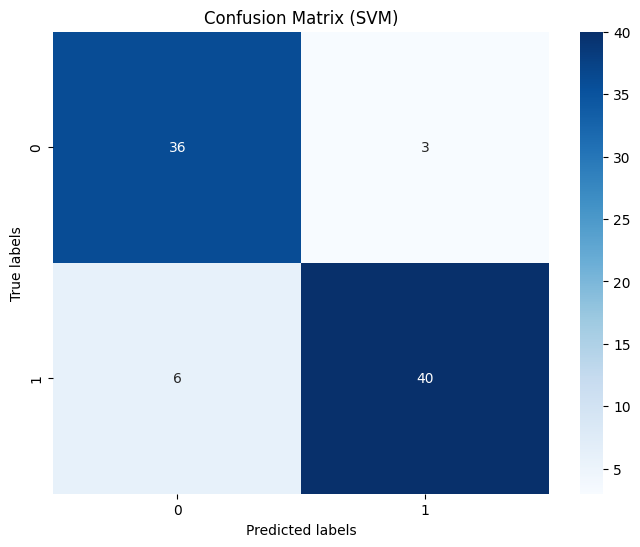

In [ ]:
model_params = {
    'C': svm_best_c,
    'kernel': svm_best_kernel,
    'degree': svm_best_degree,
    'gamma': svm_best_gamma,
    'max_iter': 10000,
    'random_state': 42
}

x_train_val = np.concatenate((x_train, x_val), axis=0)
y_train_val = np.concatenate((y_train, y_val), axis=0)

svm_best_model = SVC(**model_params)

svm_best_model.fit(x_train_val, y_train_val)

svm_predictions = svm_best_model.predict(x_test)
svm_recall = recall_score(y_test, svm_predictions, pos_label=1) * 100
svm_accuracy = accuracy_score(y_test, svm_predictions) * 100

print(f"The recall of the best SVM model: {svm_recall:.2f}%")
print(f"The accuracy of the best SVM model: {svm_accuracy:.2f}%")

confusion_matrix_svm = confusion_matrix(y_test, svm_predictions)

plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix_svm, annot=True, fmt="d", cmap="Blues")
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix (SVM)')
plt.show()

Results for the second best SVM model:
The recall of the second best SVM model: 91.30%
The accuracy of the second best SVM model: 90.59%


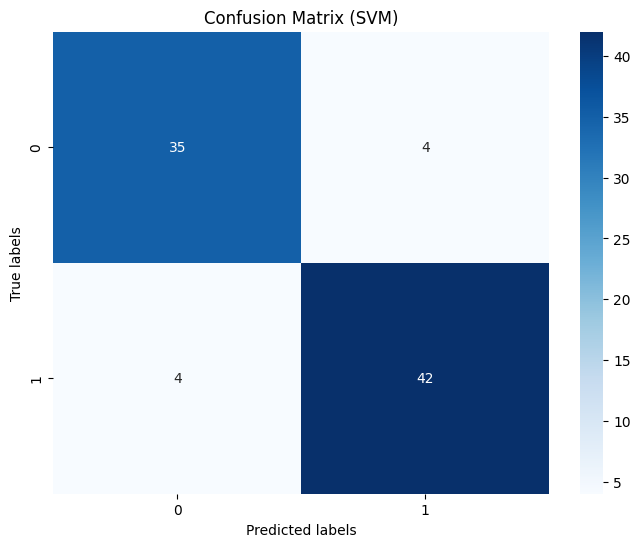

In [ ]:
svm_second_best_c, svm_second_best_kernel, svm_second_best_gamma, svm_second_best_degree, _, _ = all_results_svm[1]

model_params_second_best = {
    'C': svm_second_best_c,
    'kernel': svm_second_best_kernel,
    'degree': svm_second_best_degree,
    'gamma': svm_second_best_gamma,
    'max_iter': 10000,
    'random_state': 42
}

svm_second_best_model = SVC(**model_params_second_best)

svm_second_best_model.fit(x_train_val, y_train_val)

svm_second_best_predictions = svm_second_best_model.predict(x_test)

svm_second_best_recall = recall_score(y_test, svm_second_best_predictions, pos_label=1) * 100
svm_second_best_accuracy = accuracy_score(y_test, svm_second_best_predictions) * 100

print("Results for the second best SVM model:")
print(f"The recall of the second best SVM model: {svm_second_best_recall:.2f}%")
print(f"The accuracy of the second best SVM model: {svm_second_best_accuracy:.2f}%")

confusion_matrix_svm2 = confusion_matrix(y_test, svm_second_best_predictions)

plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix_svm2, annot=True, fmt="d", cmap="Blues")
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix (SVM)')
plt.show()


MLP Classifier

In [ ]:
from sklearn.neural_network import MLPClassifier

alphas = [1, 0.1, 0.01, 0.001]
hidden_layer_sizes = [(8, 8, 8), (16, 16), (32, 32), (64, 64)]
solvers = ["adam", "sgd", "lbfgs"]
activation_functions = ["relu", "logistic", "tanh"]

mlp_hyperparams = list(product(hidden_layer_sizes, alphas, solvers, activation_functions))

all_results_mlp = []
for size, alpha, solver, activation_function in mlp_hyperparams:
    model_params = {'hidden_layer_sizes': size, 'activation': activation_function, 'solver': solver,
                    'alpha': alpha, 'max_iter': 100000, 'random_state': 42}
    model = MLPClassifier(**model_params)
    model.fit(x_train, y_train)
    predictions = model.predict(x_val)
    val_recall = recall_score(y_val, predictions, pos_label=1) * 100
    val_accuracy = accuracy_score(y_val, predictions) * 100
    all_results_mlp.append((size, activation_function, solver, alpha, val_recall, val_accuracy))

all_results_mlp.sort(key=lambda item: (item[5], item[4]), reverse=True)

best_result_mlp = all_results_mlp[0]
mlp_best_size, mlp_best_activation_function, mlp_best_solver, mlp_best_alpha, mlp_best_val_recall, mlp_best_val_acc = best_result_mlp

print(f'The settings of the best MLP model: size={mlp_best_size}, alpha={mlp_best_alpha}, solver={mlp_best_solver}, activation_function={mlp_best_activation_function}')
print(f'The best validation recall: {mlp_best_val_recall:.2f}%')
print(f'The best validation accuracy: {mlp_best_val_acc:.2f}%')

headers_mlp = ["Hidden Layer Sizes", "Activation Function", "Solver", "Alpha", "Validation Recall (%)", "Validation Accuracy (%)"]

table_data_mlp = [[size, activation_function, solver, alpha, val_recall, val_accuracy] for size, activation_function, solver, alpha, val_recall, val_accuracy in all_results_mlp]
print(tabulate(table_data_mlp, headers=headers_mlp))

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL N

The settings of the best MLP model: size=(8, 8, 8), alpha=0.001, solver=lbfgs, activation_function=tanh
The best validation recall: 96.23%
The best validation accuracy: 91.76%
Hidden Layer Sizes    Activation Function    Solver      Alpha    Validation Recall (%)    Validation Accuracy (%)
--------------------  ---------------------  --------  -------  -----------------------  -------------------------
(8, 8, 8)             tanh                   lbfgs       0.001                  96.2264                    91.7647
(16, 16)              relu                   lbfgs       0.1                    90.566                     89.4118
(32, 32)              relu                   adam        0.1                    88.6792                    88.2353
(16, 16)              relu                   lbfgs       1                      86.7925                    88.2353
(16, 16)              tanh                   lbfgs       1                      86.7925                    88.2353
(16, 16)           

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


The final recall of the best MLP model = 95.65%
The final accuracy of the best MLP model = 85.88%


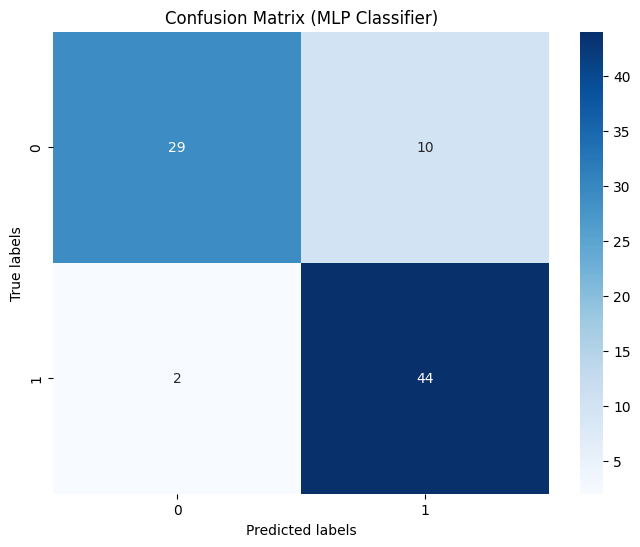

In [ ]:
from sklearn.neural_network import MLPClassifier

model_params_mlp = {
    'hidden_layer_sizes': mlp_best_size,
    'activation': mlp_best_activation_function,
    'solver': mlp_best_solver,
    'alpha': mlp_best_alpha,
    'max_iter': 100000,
    'random_state': 42,
}

x_train_val = np.concatenate((x_train, x_val), axis=0)
y_train_val = np.concatenate((y_train, y_val), axis=0)

mlp_best_model = MLPClassifier(**model_params_mlp)

mlp_best_model.fit(x_train_val, y_train_val)

mlp_predictions = mlp_best_model.predict(x_test)
mlp_recall = recall_score(y_test, mlp_predictions, pos_label=1) * 100
mlp_accuracy = accuracy_score(y_test, mlp_predictions) * 100

print(f"The final recall of the best MLP model = {mlp_recall:.2f}%")
print(f"The final accuracy of the best MLP model = {mlp_accuracy:.2f}%")

confusion_matrix_mlp = confusion_matrix(y_test, mlp_predictions)

plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix_mlp, annot=True, fmt="d", cmap="Blues")
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix (MLP Classifier)')
plt.show()

In [ ]:
import csv

with open('table_data.csv', 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerows(table_data)

with open('table_data_mlp.csv', 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerows(table_data_mlp)